<a href="https://colab.research.google.com/github/manualrg/dslab-nlp-dl/blob/master/02_intronlp_topicmodel_ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modelling: LSA y LDA

In [ ]:
import typing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import nltk

from sklearn.datasets import fetch_20newsgroups
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize

In [ ]:
print(f"{sklearn.__version__=}")
print(f"{nltk.__version__=}")
print(f"{pd.__version__=}")

sklearn.__version__='1.6.1'
nltk.__version__='3.9.1'
pd.__version__='2.2.2'


In [ ]:
RND_SEED = 123
PCT_TEST = 0.2

# Dataset

In [ ]:
categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]
remove = ('headers', 'footers', 'quotes')
def load_dataset(categories, remove=(), random_state = 123):
    """Load and vectorize the 20 newsgroups dataset."""

    data_train = fetch_20newsgroups(
        subset="train",
        categories=categories,
        shuffle=True,
        random_state=random_state,
        remove=remove,
    )

    data_test = fetch_20newsgroups(
        subset="test",
        categories=categories,
        shuffle=True,
        random_state=random_state,
        remove=remove,
    )

    y_train, y_test = data_train.target, data_test.target
    X_train, X_test = data_train.data, data_test.data
    labels = data_train.target_names


    return  (X_train,  # list[str]
    X_test, # list[str]
    y_train,  #array[int]
    y_test,  # array[int]
    labels  # list[str]
             )

def viz_example(X, y, labels, idx):
  print("text:", X[idx])
  print("label index:", y[idx])
  print("label:", labels[y[idx]])

#viz_example(X_train, y_train, labels, 0)

In [ ]:

# Load the dataset
X_train_valid, X_test, y_train_valid, y_test, labels = load_dataset(categories, remove=('headers', 'footers', 'qutes'))

In [ ]:
pd.Series(y_train_valid).value_counts(normalize=True)

,proportion
2,0.291544
1,0.287119
0,0.235988
3,0.185349


In [ ]:
len(y_train_valid)

2034

# Split Train/Test

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid,
    y_train_valid,
    test_size=0.3,
    random_state=RND_SEED,
    stratify=y_train_valid
)


# LSA (TruncatedSVD)

Explained Variance: Porcentaje de variacion en los datos explicada por la nueva matriz tamaño (N, K)

¿Qué Vectorización es la más adecuada?

In [ ]:
# prompt: usar el dataset `fetch_20newsgroups` cargado como X_train, X_test, y_train, y_test para construir una demostrcion de topic modelling, la cual debe incluir:
# 1. construir una pipeline de scikit learn para implementar un modelo de LSA mediante el modelo de TruncatedSVD, justificando el uso del mismo, usando TFIDFVectorizer y justificando la eleccion, ensayando un par de valores de numero de topics y comparando resultados, justificando  la eleccion de uno. Añadir algunas visualizaciones interesantes
# 2. construir una pipeline de scikit learn para implementar un modelo de LDA, justificando el uso del mismo, justificando la eleccion de la vectorizacion, ensayando un par de valores de numero de topics y comparando resultados, justificando  la eleccion de uno. Añadir algunas visualizaciones interesantes

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score


lst_explained = []
lst_svd_models = []


for i, max_df in enumerate([0.25, 0.15, 0.1]):
  for i, min_df in enumerate([5, 10]):
    for i, max_features in enumerate([1024]):
      for i, n_components in enumerate([2, 4, 10]):
        # Feature Engineering
        fte_tfidf_exp1 = TfidfVectorizer(max_df = max_df, min_df = min_df, max_features = max_features, stop_words='english')
        X_train_fte_exp1 = fte_tfidf_exp1.fit_transform(X_train)
        X_valid_fte_exp1 = fte_tfidf_exp1.transform(X_valid)

        _svd = TruncatedSVD(
            algorithm="arpack", # randomized es mas rapido, pero hay que tunear mas parametros
            n_components=n_components,
            random_state=RND_SEED
            )
        _svd.fit(X_train_fte_exp1)
        y_preds = _svd.transform(X_valid_fte_exp1).argmax(axis=1)

        _n_features = X_train_fte_exp1.shape[1]
        _score_unsup = _svd.explained_variance_ratio_.sum()
        _score_sup = accuracy_score(y_true=y_valid, y_pred=y_preds)

        lst_explained.append(
            {"score_unsup":_score_unsup, "score_sup": _score_sup,"n_features": _n_features,
            "n_components": n_components,
            "max_df": max_df, "min_df": min_df, "max_features": max_features
            }
        )
        lst_svd_models.append(
            _svd
        )





In [ ]:
df_hpt_lsa = pd.DataFrame(lst_explained)
df_hpt_lsa

,score_unsup,score_sup,n_features,n_components,max_df,min_df,max_features
0,0.021140,0.234043,1024,2,0.25,5,1024
1,0.043167,0.281506,1024,4,0.25,5,1024
2,0.085623,0.255319,1024,10,0.25,5,1024
3,0.021197,0.234043,1024,2,0.25,10,1024
4,0.043242,0.279869,1024,4,0.25,10,1024
5,0.085853,0.253682,1024,10,0.25,10,1024
6,0.020436,0.217676,1024,2,0.15,5,1024
7,0.042676,0.256956,1024,4,0.15,5,1024
8,0.084304,0.237316,1024,10,0.15,5,1024
9,0.020492,0.217676,1024,2,0.15,10,1024


In [ ]:
_mask = ((df_hpt_lsa['n_features'] == 1024)
  &  (df_hpt_lsa['max_df'] == 0.10)
  & (df_hpt_lsa['min_df'] == 10)
)


df_n_components_champ_lsa = df_hpt_lsa.loc[_mask, ["score_unsup", "score_sup", "n_components"]]
df_n_components_champ_lsa

,score_unsup,score_sup,n_components
15,0.017688,0.343699,2
16,0.037866,0.410802,4
17,0.079251,0.361702,10


In [ ]:
df_lsa_exp_var_elbow = (df_n_components_champ_lsa
  .assign(
      elbow=lambda x: abs(x["score_sup"].diff()) / abs(x["n_components"].diff())
  )
)

df_lsa_exp_var_elbow

,score_unsup,score_sup,n_components,elbow
15,0.017688,0.343699,2,NaN
16,0.037866,0.410802,4,0.033552
17,0.079251,0.361702,10,0.008183


In [ ]:
se_expvar_exp1 = df_n_components_champ_lsa.set_index("n_components")["score_unsup"]

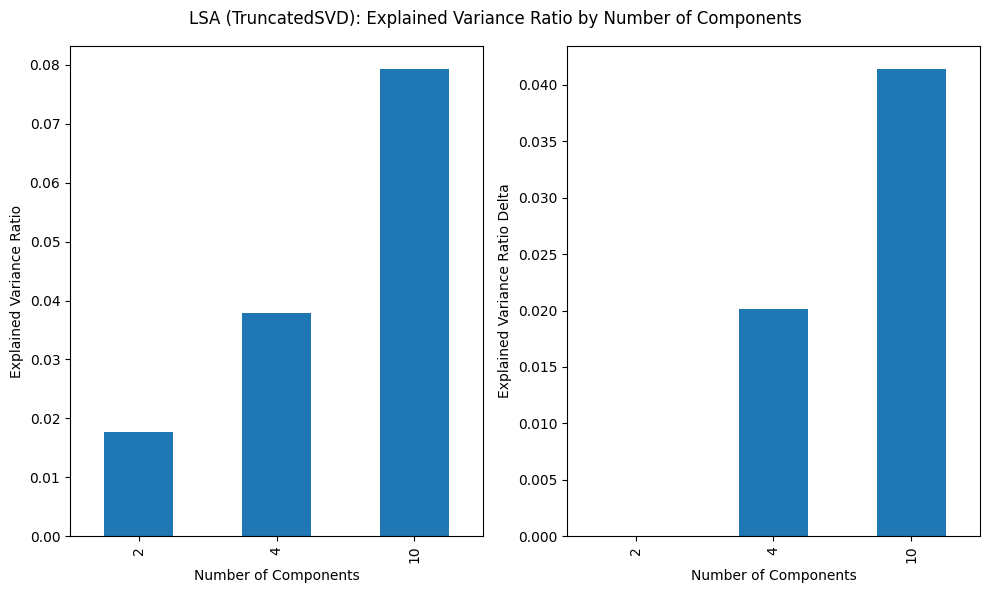

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

ax1 = axs[0]
ax2 = axs[1]
fig.suptitle('LSA (TruncatedSVD): Explained Variance Ratio by Number of Components')

se_expvar_exp1.plot(kind='bar', ax=ax1)
ax1.set_ylabel('Explained Variance Ratio')

se_expvar_exp1.diff().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Explained Variance Ratio Delta')

for ax in axs:
    ax.set_xlabel('Number of Components')

plt.tight_layout()
plt.show()


# LDA


Perplexity: Como de "sorprendido" está el modelo al recibir nuevos datos
* Bajo score de perplexity: mejor generalización

¿Qué Vectorización es la más adecuada?

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

lst_perplexity = []
lst_lda_models = []

for i, max_df in enumerate([0.5, 0.25]):
  for i, min_df in enumerate([5]):
    for i, max_features in enumerate([2048, 4096]):
      for i, n_components in enumerate([2, 4, 10]):

        # Feature Engineering
        fte_tfidf_exp2 = CountVectorizer(max_df = max_df,
                                        min_df = min_df,
                                        max_features = max_features,
                                        stop_words='english')

        X_train_fte_exp2 = fte_tfidf_exp2.fit_transform(X_train)
        X_valid_fte_exp2 = fte_tfidf_exp2.transform(X_valid)

        _lda = LatentDirichletAllocation(
            n_components=n_components,
            random_state=RND_SEED,
            n_jobs=-1
        )

        _lda.fit(X_train_fte_exp2)
        y_preds = _lda.transform(X_valid_fte_exp2).argmax(axis=1)

        _n_features = X_train_fte_exp2.shape[1]
        _score_unsup = _lda.perplexity(X_valid_fte_exp2)
        _score_sup = accuracy_score(y_true=y_valid, y_pred=y_preds)

        lst_perplexity.append(
            {"score_unsup":_score_unsup, "score_sup": _score_sup,"n_features": _n_features,
            "n_components": n_components,
             "max_df": max_df, "min_df": min_df, "max_features": max_features,
            }
        )
        lst_lda_models.append(
            _lda
        )





In [ ]:
df_hpt_lda = pd.DataFrame(lst_perplexity)
df_hpt_lda

,score_unsup,score_sup,n_features,n_components,max_df,min_df,max_features
0,1284.611323,0.489362,2048,2,0.50,5,2048
1,1329.265353,0.685761,2048,4,0.50,5,2048
2,1695.897416,0.271686,2048,10,0.50,5,2048
3,2329.274739,0.499182,4096,2,0.50,5,4096
4,2516.745363,0.641571,4096,4,0.50,5,4096
5,3564.364534,0.150573,4096,10,0.50,5,4096
6,1383.404964,0.022913,2048,2,0.25,5,2048
7,1436.333591,0.364975,2048,4,0.25,5,2048
8,1878.661463,0.180033,2048,10,0.25,5,2048
9,2515.063831,0.019640,4096,2,0.25,5,4096


In [ ]:
_mask = ((df_hpt_lda['n_features'] == 2048)
  &  (df_hpt_lda['max_df'] == 0.50)
  & (df_hpt_lda['min_df'] ==5)
)


df_n_components_champ_lda = df_hpt_lda.loc[_mask, ["score_unsup", "score_sup", "n_components"]]
df_n_components_champ_lda

,score_unsup,score_sup,n_components
0,1284.611323,0.489362,2
1,1329.265353,0.685761,4
2,1695.897416,0.271686,10


# Champion

In [ ]:
len(X_test)

1353

In [ ]:
lst_perplexity = []
lst_lda_models = []

from sklearn.pipeline import Pipeline

MAX_DF = 0.5
MIN_DF = 5
MAX_FEATURES = 2048
N_COMPONENTS = 4
# Feature Engineering
fte_tfidf_champ = CountVectorizer(max_df = max_df,
                                min_df = min_df,
                                max_features = max_features,
                                stop_words='english')

X_train_valid_fte = fte_tfidf_champ.fit_transform(X_train_valid)
X_test_fte = fte_tfidf_champ.transform(X_test)

lda = LatentDirichletAllocation(
    n_components=N_COMPONENTS,
    random_state=RND_SEED,
    n_jobs=-1
)

lda.fit(X_train_valid_fte)
y_preds_champ = lda.transform(X_test_fte).argmax(axis=1)

_n_features = X_train_valid_fte.shape[1]
perpexity_champ = lda.perplexity(X_test_fte)
acc_champ = accuracy_score(y_true=y_test, y_pred=y_preds_champ)


In [ ]:
print(f"{acc_champ=}")

acc_champ=0.688839615668884


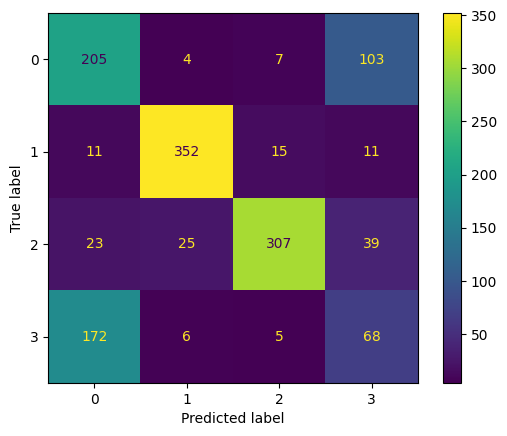

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
   y_true=y_test, y_pred=y_preds_champ,
)

plt.show()

In [ ]:
# prompt: display in a dataframe each topic most important 5 words

import pandas as pd
def get_top_n_words(model, feature_names, n_top_words):
    top_words = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words[f"Topic {topic_idx}"] = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    return pd.DataFrame(top_words)

# Assuming 'lda' is your trained LDA model and 'fte_tfidf_champ' is your CountVectorizer
feature_names = fte_tfidf_champ.get_feature_names_out()
df_top_words = get_top_n_words(lda, feature_names, 5)
df_top_words


,Topic 0,Topic 1,Topic 2,Topic 3
0,god,image,space,people
1,people,graphics,nasa,com
2,jesus,file,launch,objective
3,com,software,earth,moral
4,does,files,orbit,morality


In [ ]:
def document_topic_mixture(model, vectorizer, document: str, labels = None):
  if labels is None:
    labels = [f"Topic {i}" for i in range(model.n_components)]

  doc_vectorized = vectorizer.transform([document])

  # Get topic probabilities for the document
  topic_probabilities = model.transform(doc_vectorized)

  return pd.DataFrame(
      data=topic_probabilities,
      columns=labels
  ).assign(
      doc=document
  )


new_document = "This document is about space exploration, especially around the Solar System."
df_doc_topics =  document_topic_mixture(lda, fte_tfidf_champ, new_document)
df_doc_topics


,Topic 0,Topic 1,Topic 2,Topic 3,doc
0,0.042965,0.042811,0.871109,0.043116,"This document is about space exploration, espe..."


In [ ]:
vec_query = df_doc_topics.loc[0, ["Topic 0", "Topic 1", "Topic 2", "Topic 3"]].values
vec_query

array([np.float64(0.042964703470977694), np.float64(0.04281075184622012),
       np.float64(0.8711088699229553), np.float64(0.043115674759846845)],
      dtype=object)

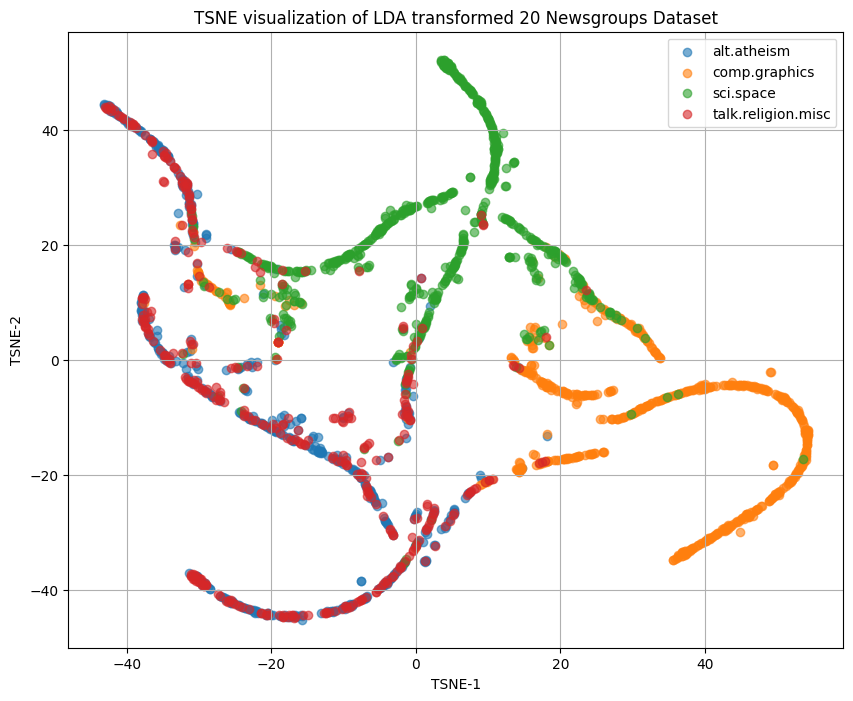

In [ ]:
# prompt: plot to visualize in 2d with t-sne dimesioality reduction the lda transformed dtaset

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Reduce dimensionality using TSNE
tsne = TSNE(n_components=2, random_state=RND_SEED, perplexity=30)
X_lda_reduced = lda.transform(X_train_valid_fte)
X_tsne = tsne.fit_transform(X_lda_reduced)

# Create a DataFrame for plotting
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE-1', 'TSNE-2'])
df_tsne['target'] = y_train_valid

# Plot the results
plt.figure(figsize=(10, 8))
for i, label in enumerate(labels):
    mask = df_tsne['target'] == i
    plt.scatter(df_tsne.loc[mask, 'TSNE-1'], df_tsne.loc[mask, 'TSNE-2'], label=label, alpha=0.6)

plt.title('TSNE visualization of LDA transformed 20 Newsgroups Dataset')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.legend()
plt.grid(True)
plt.show()

# Ejercicio: Indexado y búsqueda

Tanto LSA como LDA reducen la dimensionalidad de la DTM, siendo cada documento representado por un vector `denso`

[Vector Search Explained. Weviate](https://weaviate.io/blog/vector-search-explained)

Dada la siguiente implementación en Python de la distancia coseno

```python
import numpy as np

def cosine_distance(a, b):
    """Calculates the cosine distance between two vectors."""
    a = np.array(a)
    b = np.array(b)
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    similarity = dot_product / (norm_a * norm_b)
    distance = 1 - similarity
    return distance
  ```

1. Codificar todo el corpus de 20newsgroup con un modelo de LSA
2. Obtener la DTM en su representación densa, es decir con K columnas, esto será el índice
3. Seleccionar un documento de corpus y usarlo como consulta Q
4. Comparar el documento Q con todo el indice, el mas parecido será el mismo, determinar los más parecidos
  